# Recreating the SED from the Decomposed Components
This is intended to be a slightly more rigiourous approach to the problem of recreating the SEDs from the decomposed components. We expect to see different types of SEDs, in particular we wil see some AGN type 1, and some AGN type 2. It is essentially that we explore these difference and try to recreate our SEDs from the decomposed components, but plugging the SED into my code and seeing what comes out.

In [209]:
# Import all relevant libraries
# Begin by importing all relevant libraries and packages
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u
import numpy as np
import pandas as pd
import os
from astLib import astSED
import astropy.io.fits as fits
from carf import * # custom module for functions relating to the project
import matplotlib.path as mpath


# So that we can change the helper functions without reloading the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [210]:
# Filters
pb_U_path = os.path.join('datasets', 'Filters', 'Generic_Johnson.U.dat')
pb_V_path = os.path.join('datasets', 'Filters', 'Generic_Johnson.V.dat')
pb_J_path = os.path.join('datasets', 'Filters', '2MASS_2MASS.J.dat')


pb_U = astSED.Passband(pb_U_path, normalise=False)
pb_V = astSED.Passband(pb_V_path, normalise=False)
pb_J = astSED.Passband(pb_J_path, normalise=False)

In [211]:
# We will be employing the use of the Skirtor models to add AGN back into the decomposed SEDs
tau = SKIRTOR_PARAMS['tau'][3]
p = SKIRTOR_PARAMS['p'][0]
q = SKIRTOR_PARAMS['q'][0]
oa = SKIRTOR_PARAMS['oa'][4]
rr = SKIRTOR_PARAMS['rr'][2]
i = SKIRTOR_PARAMS['i'][0]

# Skirtor folder
skirtor_folderpath = os.path.join('datasets', 'Templates', 'Skirtor')

# This is our type-1 AGN model
agn_model = read_skirtor_model(skirtor_folderpath, tau, p, q, oa, rr, i)


In [212]:
# Get the df 
queiscent_transitions = pd.read_csv('outputs\quiescent_transition_ids.csv')



def get_n_seds(df, n, restframe=False, all=False):
    # Select n galaxies
    
    df_list = []
    names = []
    redshifts = []
    if all==False:
        selected_galaxies = df.sample(n)
    else: 
        selected_galaxies = df
        
    # Reset the index
    selected_galaxies = selected_galaxies.reset_index(drop=True)
    
    # name 
    gal_name = selected_galaxies['id'].astype(str)
    
    # field
    gal_field = selected_galaxies['field'].astype(str)
    
    
    names = gal_field + '_' + gal_name
    gal_redshift = selected_galaxies['zpk'].astype(float)

    # Now we will read in the fits files for these galaxies

    for i in range(len(selected_galaxies)):
        path = 'datasets\student_fits_files\\'+ str(gal_field[i]).lower() +'_best_models_fits\\'
        name = str(gal_name[i])+'_best_model.fits'

        galaxy_path = os.path.join(path, name)
        with fits.open(galaxy_path) as data:
            df = pd.DataFrame(np.array(data[1].data).byteswap().newbyteorder())
        
        # Convert to angstroms
        df['wavelength'] = df['wavelength']*10

        if restframe:
            df['Snu'] = df['Fnu']*10**-3 # milliJanksys to Janksys <- J = ergs/(s*(cm^2)*(s^-1))
            # F_nu currently has a frequency dependence, convert to nuFnu by multiplying the the frequency associated
            # with the wavelength, as we are in angstroms, we can use the formula c = f*lambda
            
            
            # This should prevent any issues, but check
            freq = (3*10**18)/df['wavelength'] # in Hz
            # multiply the Snu * nu to get nuSnu
            df['nuSnu'] = df['Snu']*freq
            # Restframe the values of wavelength
            df['wavelength'] = df['wavelength'] / (1 + gal_redshift[i]) # we redshift the values of of wavelength
            # now calculate a new frequency, based on the new wavelength
            freq = (3*10**18)/df['wavelength'] # in Hz
            # divide the nuSnu by the new frequency to get the restframed values
            df['Snu'] = df['nuSnu']/freq
            
            # Convert flux values
            df['Flambda'] = df['Snu']*(3*10**-5)/(df['wavelength']**2) # S_nu to F_lambda <- angstroms 
            
        else:
            # Convert flux values
            df['Snu'] = df['Fnu']*10**-3 # milliJanksys to Janksys <- J = ergs/(s*(cm^2)*(s^-1))
            df['Flambda'] = df['Snu']*(3*10**-5)/(df['wavelength']**2) # S_nu to F_lambda <- angstroms 
            
        
            
            
        redshift_Val = gal_redshift[i]
        redshifts.append(redshift_Val)        
        
        

        
        # For simplicity, just create some extra columns
        df['lambda (Angstroms)'] = df['wavelength']
        df['Total Flux (erg/s/cm^2/Angstrom)'] = df['Flambda']
        
        
        
        df_list.append(df)
        
        
        plt.loglog(df['wavelength'], df['Flambda'])
    plt.xlabel('Wavelength (Angstroms)')
    plt.ylabel('Flux (Fnu)')
    #plt.xlim(1e3, 1e5)
    plt.ylim(1e-30, 1e-2)
    plt.title('SED of galaxies')
    plt.legend()
    plt.show()
    
    print(len(df_list))
    
    return df_list, names, redshifts

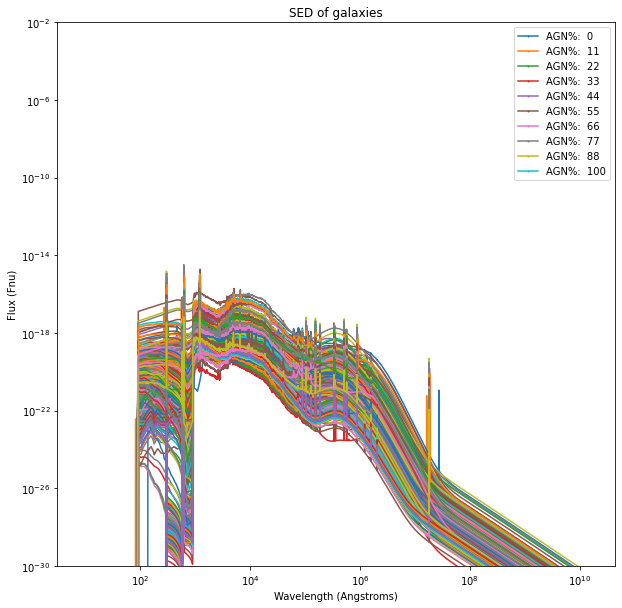

439


In [213]:
zfourge_decomposed_seds, names, redshifts = get_n_seds(queiscent_transitions, 5, restframe=True, all=True)

In [214]:
# We only want to investigate the decomposed SED IDs that have been output: Decomposed_UVJ_Ids
# We will use the IDs to select the galaxies we want to investigate
decomposed_UVJ_ids = pd.read_csv('Decomposed_UVJ_Ids.csv')

In [215]:
decomposed_UVJ_ids['id'] 

0      CDFS_22468
1      CDFS_11857
2      CDFS_18441
3      CDFS_15163
4      CDFS_25294
          ...    
143      UDS_7946
144     UDS_15368
145     UDS_15080
146      UDS_9060
147     UDS_17475
Name: id, Length: 148, dtype: object

In [216]:
names

0      CDFS_22468
1      CDFS_16807
2      CDFS_11281
3      CDFS_10413
4      CDFS_13143
          ...    
434     UDS_13883
435      UDS_1887
436     UDS_17475
437     UDS_19012
438     UDS_14976
Length: 439, dtype: object

In [217]:
# Using the id's from the decomposed UVJ ids, we can select the galaxies we want to investigate at a particular index


# use the decomposed_UVJ_ids['id'] to selected the appropriate names, `names` and `zfourge_decomposed_seds`
# find 
#decomposed_UVJ_ids['id']
#names
#zfourge_decomposed_seds

# Whereever there is a match between the ids, return the index number in the names df

#decomposed_UVJ_ids['id'].isin(names)
names.isin(decomposed_UVJ_ids['id'])

# count the trues
names.isin(decomposed_UVJ_ids['id']).sum()


# find the index of each of the trues
galaxy_index = names[names.isin(decomposed_UVJ_ids['id'])].index


In [218]:
# Add names, redshifts, and decomposed seds into a multidimensional array

SED_df = [[], [], []]
print(len(galaxy_index))
for i in galaxy_index:
    print(i)
    SED_df[0].append(names[i]) # ID of galaxy
    SED_df[1].append(redshifts[i]) # Redshift of galaxy
    SED_df[2].append(zfourge_decomposed_seds[i]) # Full SED of galaxy
    print('\n')

148
0


6


12


18


29


30


34


37


41


50


55


56


64


65


67


73


74


76


77


80


90


96


108


111


113


117


124


129


143


148


149


150


151


154


155


157


159


161


166


167


168


170


171


172


177


184


185


188


189


190


191


197


198


201


202


204


205


206


208


211


215


219


224


230


231


233


235


237


238


240


241


243


247


249


254


256


259


265


267


269


274


277


278


280


284


285


290


291


292


293


295


297


300


303


304


307


308


309


310


315


317


320


321


326


327


328


330


331


333


339


340


343


347


348


350


352


353


354


357


361


362


363


364


365


368


371


381


390


391


395


396


398


401


403


404


405


407


411


415


416


418


420


421


422


426


427


428


436




In [219]:
# Now we have our selection of SEDs from our inital sample that contain AGN features
# we will reproccess these these SEDS to ensure 


def decompose_agn_seds(best_fit_seds):
    # Create a list to store the decomposed SEDs
    decomposed_seds = []
    
    # Iterate through the best_fit_seds
    for i in range(len(best_fit_seds)):
        new_df = best_fit_seds[i].copy()
        
        # Drop the zero values - maybe include this potentially
       # new_df = df[df['L_lambda_total'] > 10**-7].copy()

        # AGN components - Remove the galaxy component
        # Create an adjust L_lambda to plot against
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total']

        # Remove the young and old stellar components
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['stellar.old']
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['stellar.young']


        # Remove the absopriton and emission lines

        # Absorption
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['nebular.absorption_old']
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['nebular.absorption_young']

        # Emission
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['nebular.lines_old']
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['nebular.lines_young']


        # Removing the dust component
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['dust']


        # Removing the galactic continuum
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['nebular.continuum_old']
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['nebular.continuum_young']

        # Removing the attentuated components
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['attenuation.stellar.old']
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['attenuation.stellar.young']
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['attenuation.nebular.lines_old']
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['attenuation.nebular.lines_young']
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['attenuation.nebular.continuum_old']
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['attenuation.nebular.continuum_young']


        # Remove the igm
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['igm']
        
        integral_total = np.trapz(new_df['L_lambda_total'], new_df['wavelength'])
        integral_decomposed = np.trapz(new_df['L_lambda_total_decomposed_AGN'], new_df['wavelength'])

        # Scaling factor
        scaling_factor = integral_total/integral_decomposed

        # Normalise the decomposed values <- Unsure if we should be doing this, but for complenetess it may be a good idea
        new_df['L_lambda_total_decomposed_AGN_Scaled'] = new_df['L_lambda_total_decomposed_AGN'] * scaling_factor
        
        

        # Galaxy component - Remove the AGN Component
        # Create an adjust L_lambda to plot against
        new_df['L_lambda_total_decomposed'] = new_df['L_lambda_total']

        # To ensure this is done correctly, we also are choosing to consider simply just the AGN components 
        # where the the values are within a range of 10^2 - 10^7
        new_df = new_df[(new_df['wavelength'] > 10**-2) & (new_df['wavelength'] < 10**7)]

        # We would like to remove the AGN from the galaxy if possible
        
        ####
        # Some galaxies will contain a fit for each AGN component
        # and others may not. Try later to explore this.
        ####
        
        
        
        # Removing polar dust
        new_df['L_lambda_total_decomposed'] = new_df['L_lambda_total_decomposed'] - new_df['agn.SKIRTOR2016_polar_dust']

        # Removing torus
        new_df['L_lambda_total_decomposed'] = new_df['L_lambda_total_decomposed'] - new_df['agn.SKIRTOR2016_torus']

        # Removing the accretion disk
        new_df['L_lambda_total_decomposed'] = new_df['L_lambda_total_decomposed'] - new_df['agn.SKIRTOR2016_disk']

        # normalise the values using the integral of the total flux of the original SED
        # We will use the trapezoidal rule to calculate the integral of the total flux
        # We will then divide the decomposed values by this integral to normalise the values
        integral_total = np.trapz(new_df['L_lambda_total'], new_df['wavelength'])
        integral_decomposed = np.trapz(new_df['L_lambda_total_decomposed'], new_df['wavelength'])

        # Scaling factor
        scaling_factor = integral_total/integral_decomposed

        # Normalise the decomposed values <- Unsure if we should be doing this, but for complenetess it may be a good idea
        new_df['L_lambda_total_decomposed_Scaled'] = new_df['L_lambda_total_decomposed'] * scaling_factor
        
        
        # For the purposes of using these SEDs in my code, we will create two new columns which have a specific label
        # wavelength
        new_df['lambda (Angstroms)'] = new_df['wavelength']
        new_df['Total Flux (erg/s/cm^2/Angstrom)'] = new_df['L_lambda_total_decomposed']
        
        
        decomposed_seds.append(new_df)
        
    return decomposed_seds 

In [220]:
SED_df[2] = decompose_agn_seds(SED_df[2])


In [221]:
len(SED_df[2])

148

Now we want to attempt to recreate some of the results. In essence we want the decomposed SED to be roughly returned to it's previous position
when we add our AGN model back in



A bassic approach to this may be to run the before and after UVJ colours: which we already have for each ID.
Progressively adding the AGN components back in until we see a relatively similar UVJ colour to the original.

For starters we would like to simply just worry about putting the current SEDs through the original code to generate UVJ colours





In [222]:
# Now that we have both a set of decomposed SEDs (our decomposed templates in a sense)
# So the set of templates is: SED_df[2]

# set an alpha array
alpha_values = np.linspace(0, 1, 11)



In [223]:
alpha_values

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [224]:

SED_decomposed_composites_df = generate_composite_set(agn_model, SED_df[2], alpha_values)

In [225]:
SED_decomposed_composites_df[0]

[      lambda (Angstroms)  Total Flux (erg/s/cm^2/Angstrom)
 0           1.529788e+01                      0.000000e+00
 1           1.737801e+01                      0.000000e+00
 2           1.756432e+01                      0.000000e+00
 3           1.995262e+01                      0.000000e+00
 4           2.016653e+01                      0.000000e+00
 ...                  ...                               ...
 3583        9.944754e+06                      1.602218e+28
 3584        9.952217e+06                      1.596259e+28
 3585        9.959681e+06                      1.590300e+28
 3586        9.967145e+06                      1.584341e+28
 3587        9.974609e+06                      1.578382e+28
 
 [3588 rows x 2 columns],
       lambda (Angstroms)  Total Flux (erg/s/cm^2/Angstrom)
 0           1.000000e+01                      0.000000e+00
 1           1.148154e+01                      0.000000e+00
 2           1.148154e+01                      0.000000e+00
 3          

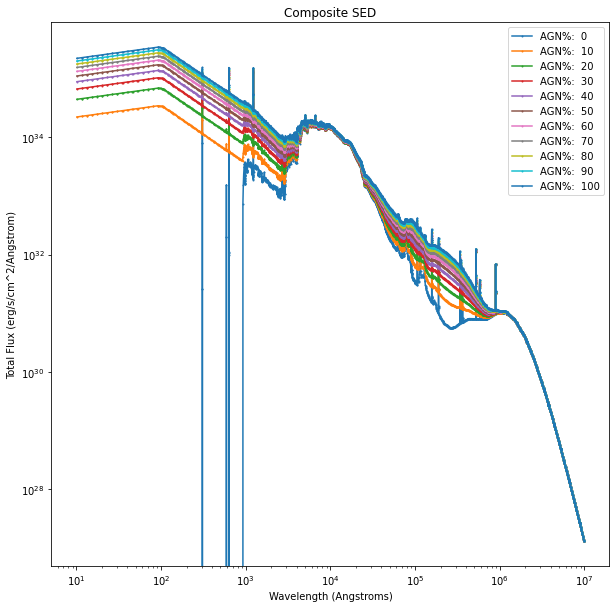

In [226]:
# We can not plot the SEDs
plt.figure(figsize=(10, 10))
# Plot agn normalized seds from the df_list
v = 90
for i in range(0, 11):
    print()
    plt.loglog(SED_decomposed_composites_df[i][v].iloc[:, 0], SED_decomposed_composites_df[i][v].iloc[:, 1], marker='o', markersize=1, label='AGN%:  {}'.format(int(alpha_values[i]*100)))
# data label

plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Total Flux (erg/s/cm^2/Angstrom)')
# Show lims
#plt.ylim(10**-1, 10**3)
#plt.xlim(10**3, 10**5)

plt.title('Composite SED')
plt.legend()
plt.show()

In [227]:
# We would now like to attempt to recreate some of the colours
uv_specific_alpha_colours = []
vj_specific_alpha_colours = []
new_objname_alpha_list = []
uv_colours =[]
vj_colours = []
new_objname_list = []
alpha_bad = []
bad_id = []
good_id = []
alpha_good = []

for i in range(len(alpha_values)):
    # This will be the set of composites for the specific alpha value
    sed_alpha_data = SED_decomposed_composites_df[i] # should go through each
    
    for j, sed_data in enumerate(sed_alpha_data): # will go through each of the zfourge galaxies
        # Create an SED object using astSED
        wl = sed_data['lambda (Angstroms)']
        fl = sed_data['Total Flux (erg/s/cm^2/Angstrom)']
        sed = astSED.SED(wavelength=wl, flux=fl, z=0.0)  
        
        # The id of this particular entry is the objname_list[j]
        objname = names[j]
        
        
        # We assume there will be some bad SEDs
        try:
            uv = astSED.SED.calcColour(sed, pb_U, pb_V, magType='AB')
            vj = astSED.SED.calcColour(sed, pb_V, pb_J, magType='AB')
            
            # Try calculate the u mag and the v mag and the j mag seperately as fluxes
            # flux
            # u_mag = astSED.SED.calcMag(sed, pb_U, magType='AB')
            # v_mag = astSED.SED.calcMag(sed, pb_V, magType='AB')
            # j_mag = astSED.SED.calcMag(sed, pb_J, magType='AB')
            
            # uv = u_mag - v_mag
            # vj = v_mag - j_mag
            # Append the uv, vj and name to their relevant lists
            uv_colours.append(uv)
            vj_colours.append(vj)
            new_objname_list.append(objname)
        except:
            # Add the bad id to the bad id list
            bad_id.append(j)
            
            #print('Bad SED:', objname)
            #del df_list[i][j] # This should delete the jth entry from the ith list
            #del objname_list[j] # this should delete the associated name
            continue
        
    # Append the uv, and vj colours     
    uv_specific_alpha_colours.append(uv_colours)
    vj_specific_alpha_colours.append(vj_colours)
    alpha_bad.append(bad_id) # append the bad id list - so then we can find the bad idea for each alpha
    new_objname_alpha_list.append(new_objname_list)
    # Reset the colours for the next set of alpha values
    uv_colours = []
    vj_colours = []
    bad_id = []
    new_objname_list = []


In [228]:
print(len(uv_specific_alpha_colours[0]))
print(len(vj_specific_alpha_colours[0]))

148
148


In [240]:
ids = new_objname_alpha_list[0]


# add the field prefix to the IDs
ids = [str(x) for x in ids]

In [241]:
# Create a dataframe with all the id's 
df = pd.DataFrame(data={'ID': ids})

In [242]:
df

,ID
0,CDFS_22468
1,CDFS_16807
2,CDFS_11281
3,CDFS_10413
4,CDFS_13143
...,...
143,CDFS_25569
144,CDFS_11844
145,CDFS_20598
146,CDFS_11781


In [243]:
for i in range(len(alpha_values)):
    df['UV_{}'.format(int(alpha_values[i]*100))] = uv_specific_alpha_colours[i]
    df['VJ_{}'.format(int(alpha_values[i]*100))] = vj_specific_alpha_colours[i]

In [244]:
df

,ID,UV_0,VJ_0,UV_10,VJ_10,UV_20,VJ_20,UV_30,VJ_30,UV_40,...,UV_60,VJ_60,UV_70,VJ_70,UV_80,VJ_80,UV_90,VJ_90,UV_100,VJ_100
0,CDFS_22468,0.970617,1.883590,0.734812,1.668777,0.615337,1.517123,0.542720,1.403325,0.493814,...,0.432027,1.183446,0.411252,1.133748,0.394562,1.091367,0.380859,1.054773,0.369405,1.022839
1,CDFS_16807,0.913174,0.508098,0.894690,0.508836,0.877223,0.509543,0.860690,0.510224,0.845017,...,0.815987,0.512113,0.802517,0.512697,0.789677,0.513261,0.777423,0.513804,0.765715,0.514329
2,CDFS_11281,0.955997,0.557744,0.934514,0.557457,0.914325,0.557182,0.895312,0.556918,0.877373,...,0.844366,0.556189,0.829145,0.555964,0.814691,0.555747,0.800945,0.555539,0.787857,0.555337
3,CDFS_10413,0.702274,0.409449,0.685818,0.413586,0.670511,0.417477,0.656235,0.421142,0.642888,...,0.618639,0.430967,0.607590,0.433902,0.597176,0.436689,0.587342,0.439339,0.578041,0.441861
4,CDFS_13143,1.869882,1.448004,1.737650,1.424943,1.627828,1.403089,1.534720,1.382345,1.454501,...,1.322730,1.325958,1.267761,1.308879,1.218461,1.292559,1.173952,1.276947,1.133535,1.261996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,CDFS_25569,1.834912,1.085887,1.779846,1.079224,1.729010,1.072726,1.681883,1.066387,1.638035,...,1.558776,1.048266,1.522795,1.042507,1.488931,1.036881,1.456988,1.031382,1.426795,1.026006
144,CDFS_11844,1.869882,1.448004,1.737795,1.424971,1.628073,1.403141,1.535033,1.382419,1.454864,...,1.323154,1.326086,1.268203,1.309021,1.218916,1.292714,1.174415,1.277114,1.134003,1.262173
145,CDFS_20598,1.923775,1.192023,1.853519,1.183197,1.789803,1.174616,1.731658,1.166267,1.678310,...,1.583610,1.142531,1.541312,1.135026,1.501881,1.127712,1.465009,1.120580,1.430437,1.113625
146,CDFS_11781,1.834912,1.085887,1.779857,1.079225,1.729029,1.072729,1.681910,1.066391,1.638068,...,1.558820,1.048273,1.522844,1.042515,1.488984,1.036890,1.457044,1.031392,1.426853,1.026017


In [248]:
# Read in the decomposed UVJ ids
decomposed_UVJ_ids.rename(columns={'id': 'ID'}, inplace=True)

df

,ID,UV_0,VJ_0,UV_10,VJ_10,UV_20,VJ_20,UV_30,VJ_30,UV_40,...,UV_60,VJ_60,UV_70,VJ_70,UV_80,VJ_80,UV_90,VJ_90,UV_100,VJ_100
0,CDFS_22468,0.970617,1.883590,0.734812,1.668777,0.615337,1.517123,0.542720,1.403325,0.493814,...,0.432027,1.183446,0.411252,1.133748,0.394562,1.091367,0.380859,1.054773,0.369405,1.022839
1,CDFS_16807,0.913174,0.508098,0.894690,0.508836,0.877223,0.509543,0.860690,0.510224,0.845017,...,0.815987,0.512113,0.802517,0.512697,0.789677,0.513261,0.777423,0.513804,0.765715,0.514329
2,CDFS_11281,0.955997,0.557744,0.934514,0.557457,0.914325,0.557182,0.895312,0.556918,0.877373,...,0.844366,0.556189,0.829145,0.555964,0.814691,0.555747,0.800945,0.555539,0.787857,0.555337
3,CDFS_10413,0.702274,0.409449,0.685818,0.413586,0.670511,0.417477,0.656235,0.421142,0.642888,...,0.618639,0.430967,0.607590,0.433902,0.597176,0.436689,0.587342,0.439339,0.578041,0.441861
4,CDFS_13143,1.869882,1.448004,1.737650,1.424943,1.627828,1.403089,1.534720,1.382345,1.454501,...,1.322730,1.325958,1.267761,1.308879,1.218461,1.292559,1.173952,1.276947,1.133535,1.261996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,CDFS_25569,1.834912,1.085887,1.779846,1.079224,1.729010,1.072726,1.681883,1.066387,1.638035,...,1.558776,1.048266,1.522795,1.042507,1.488931,1.036881,1.456988,1.031382,1.426795,1.026006
144,CDFS_11844,1.869882,1.448004,1.737795,1.424971,1.628073,1.403141,1.535033,1.382419,1.454864,...,1.323154,1.326086,1.268203,1.309021,1.218916,1.292714,1.174415,1.277114,1.134003,1.262173
145,CDFS_20598,1.923775,1.192023,1.853519,1.183197,1.789803,1.174616,1.731658,1.166267,1.678310,...,1.583610,1.142531,1.541312,1.135026,1.501881,1.127712,1.465009,1.120580,1.430437,1.113625
146,CDFS_11781,1.834912,1.085887,1.779857,1.079225,1.729029,1.072729,1.681910,1.066391,1.638068,...,1.558820,1.048273,1.522844,1.042515,1.488984,1.036890,1.457044,1.031392,1.426853,1.026017


In [247]:
decomposed_UVJ_ids

,ID,VJ_withAGN,UV_withAGN,VJ_withoutAGN,UV_withoutAGN,GalaxyType,GalaxyType_NoAGN,GalaxyType_Changed,GalaxyType_100,vector_magnitude,vector_direction,field
0,CDFS_22468,1.090045,0.790783,1.883585,0.970620,1.0,2.0,1,2.0,0.813663,0.222862,CDFS
1,CDFS_11857,0.613108,0.918184,0.508098,0.913174,1.0,1.0,0,1.0,0.105129,-3.093922,CDFS
2,CDFS_18441,0.670256,0.961630,0.557744,0.955997,1.0,1.0,0,1.0,0.112653,-3.091572,CDFS
3,CDFS_15163,0.487994,0.717532,0.409449,0.702274,1.0,1.0,0,1.0,0.080013,-2.949730,CDFS
4,CDFS_25294,1.410461,1.696627,1.448004,1.869882,2.0,0.0,1,0.0,0.177276,1.357402,CDFS
...,...,...,...,...,...,...,...,...,...,...,...,...
143,UDS_7946,1.065337,1.685944,1.085887,1.834912,0.0,0.0,0,0.0,0.150379,1.433713,UDS
144,UDS_15368,1.439351,1.815656,1.448004,1.869882,0.0,0.0,0,0.0,0.054912,1.412557,UDS
145,UDS_15080,1.223027,1.926246,1.192023,1.923775,0.0,0.0,0,0.0,0.031102,-3.062079,UDS
146,UDS_9060,1.065288,1.685613,1.085887,1.834912,0.0,0.0,0,0.0,0.150714,1.433689,UDS


In [249]:

# join these two tables together, adding the columns VJ_withAGN	UV_withAGN	VJ_withoutAGN	UV_withoutAGN to the df table
new_df = pd.merge(df, decomposed_UVJ_ids, on='ID')


,ID,UV_0,VJ_0,UV_10,VJ_10,UV_20,VJ_20,UV_30,VJ_30,UV_40,...,UV_withAGN,VJ_withoutAGN,UV_withoutAGN,GalaxyType,GalaxyType_NoAGN,GalaxyType_Changed,GalaxyType_100,vector_magnitude,vector_direction,field
0,CDFS_22468,0.970617,1.883590,0.734812,1.668777,0.615337,1.517123,0.542720,1.403325,0.493814,...,0.790783,1.883585,0.970620,1.0,2.0,1,2.0,0.813663,0.222862,CDFS
1,CDFS_11857,1.473733,0.971983,1.429620,0.965020,1.388832,0.958281,1.350981,0.951758,1.315740,...,0.918184,0.508098,0.913174,1.0,1.0,0,1.0,0.105129,-3.093922,CDFS
2,CDFS_18441,1.410744,1.106698,1.320731,1.086924,1.244473,1.068519,1.178889,1.051344,1.121785,...,0.961630,0.557744,0.955997,1.0,1.0,0,1.0,0.112653,-3.091572,CDFS
3,CDFS_15163,1.834912,1.085887,1.780423,1.079296,1.730077,1.072866,1.683370,1.066592,1.639884,...,0.717532,0.409449,0.702274,1.0,1.0,0,1.0,0.080013,-2.949730,CDFS
4,CDFS_25294,2.307417,1.661252,2.115070,1.637293,1.961736,1.614420,1.835468,1.592556,1.729009,...,1.696627,1.448004,1.869882,2.0,0.0,1,0.0,0.177276,1.357402,CDFS
5,CDFS_20666,1.876289,1.453572,1.742411,1.430289,1.631413,1.408229,1.537432,1.387294,1.456549,...,1.096586,1.106698,1.410744,1.0,1.0,0,1.0,0.324833,1.313728,CDFS
6,CDFS_26267,0.955997,0.557744,0.935637,0.557472,0.916441,0.557211,0.898309,0.556960,0.881153,...,1.459537,0.971983,1.473733,0.0,0.0,0,0.0,0.044075,2.813671,CDFS
7,CDFS_26038,1.380354,0.863838,1.346827,0.859149,1.315369,0.854596,1.285784,0.850174,1.257899,...,1.373530,1.106698,1.410744,1.0,1.0,0,1.0,0.038127,1.351472,CDFS
8,CDFS_9001,2.247449,1.351854,2.145935,1.341358,2.056314,1.331142,1.976353,1.321196,1.904383,...,1.357696,0.863838,1.380354,0.0,0.0,0,0.0,0.024028,1.910139,CDFS
9,CDFS_25652,2.224884,1.318608,2.127887,1.308642,2.041863,1.298939,1.964820,1.289490,1.895253,...,1.392276,0.971983,1.473733,1.0,0.0,1,0.0,0.082118,1.697812,CDFS


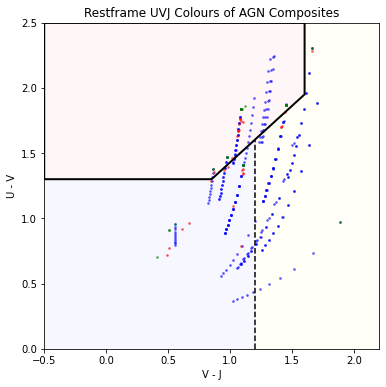

In [237]:
# Creating the same output but in the other two fields
alpha_list = np.linspace(0, 1, 11)


fig = plt.figure(figsize=(6, 6))

# Plot each value of alpha from the decomposed original UVJ colour
for alpha in alpha_list:
    plt.scatter(df['VJ_{}'.format(int(alpha*100))], df['UV_{}'.format(int(alpha*100))], c='b', s=3, alpha=0.5)

# Plot the UV_withAGN and VJ_withAGN
plt.scatter(df['VJ_withAGN'], df['UV_withAGN'], c='r', s=3, alpha=0.5)

# And UV_withoutAGN and VJ_withoutAGN
plt.scatter(df['VJ_withoutAGN'], df['UV_withoutAGN'], c='g', s=3, alpha=0.5)


    

plt.ylabel('U - V')
plt.xlabel('V - J')
plt.title("Restframe UVJ Colours of AGN Composites")
plt.xlim([-0.5, 2.2])
plt.ylim([0, 2.5])

# Plot the names
# for i in range(len(selected_ids_df)):
#     #plt.text(selected_ids_df['vj'][i], selected_ids_df['uv'][i], selected_ids_df['id'][i], fontsize=12)
#     plt.text(recalculated_df['VJ'][i], recalculated_df['UV'][i], recalculated_df['ID'][i], fontsize=12)

# Define paths for selections
path_quiescent = [[-0.5, 1.3], [0.85, 1.3], [1.6, 1.95], [1.6, 2.5], [-0.5, 2.5]]
path_sf = [[-0.5, 0.0], [-0.5, 1.3], [0.85, 1.3], [1.2, 1.60333], [1.2, 0.0]]
path_sfd = [[1.2, 0.0], [1.2, 1.60333], [1.6, 1.95], [1.6, 2.5], [2.2, 2.5], [2.2, 0.0]]

# Add patches for selections
plt.gca().add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
plt.gca().add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
plt.gca().add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))

# Add vertical line
plt.axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)

plt.show()


In [ ]:
# Now, based on where the inital AGN uvj value is, and where the recaluclated one is at alpha = 0. draw an arrow 
# to show the direction of the change

